In [22]:
import os

# Define the HuggingFace repository and local path
ct_filename = "ct.nii.gz"
pancreas_segmentations_filename = "segmentations/pancreas.nii.gz"

data_folder = "./data"
encoded_images_dir = os.path.join(data_folder, "encoded_imgs")

os.path.join(encoded_images_dir, 'enc_healthy_cubes.pkl')
import pickle

with open(os.path.join(encoded_images_dir, 'enc_healthy_cubes.pkl'), 'rb') as f:
    enc_healthy_cubes = pickle.load(f)

with open(os.path.join(encoded_images_dir, 'enc_pancreatic_tumor_cubes.pkl'), 'rb') as f:
    enc_pancreatic_tumor_cubes = pickle.load(f)

In [23]:
len(enc_healthy_cubes.values())

42

## Unfortunately some of the CTs have less than 10 samples bcs. they ended up being out of range

- [ ] TODO Reduce to min. no. samples of all CTs

In [27]:
import torch

def process_and_stack_tensors(enc_pancreatic_tumor_cubes):
    """
    Process the tensors in the dictionary:
    1. Stack the tensors, ignoring empty lists.
    2. Take tensors with at least 5 entries along the first dimension.
    3. Threshold them to 5 entries, dropping those with fewer than 5 entries.
    4. Stack all the processed tensors along a new axis.

    Parameters:
    enc_pancreatic_tumor_cubes (dict): The input dictionary with lists of tensors.

    Returns:
    torch.Tensor: A tensor with all the processed tensors stacked along a new axis.
    """
    # Stack the tensors, ignoring empty lists
    stacked_inner_lists = [torch.stack(inner_list).squeeze(1) for inner_list in enc_pancreatic_tumor_cubes.values() if inner_list]

    # Filter and reduce the tensors to have exactly 5 entries along the first dimension
    filtered_and_reduced_tensors = [tensor[:5] for tensor in stacked_inner_lists if tensor.shape[0] >= 5]

    # Stack all the processed tensors along a new axis
    if filtered_and_reduced_tensors:
        final_tensor = torch.stack(filtered_and_reduced_tensors)
    else:
        final_tensor = torch.tensor([])  # Return an empty tensor if no tensors meet the criteria

    return final_tensor

In [29]:
enc_pancreatic_tensors = process_and_stack_tensors(enc_pancreatic_tumor_cubes)
enc_healthy_tensors = process_and_stack_tensors(enc_healthy_cubes)

print(enc_pancreatic_tensors.shape)
print(enc_healthy_tensors.shape)

torch.Size([13, 5, 8, 24, 24, 24])
torch.Size([42, 5, 8, 24, 24, 24])


In [30]:
final_tensor = torch.cat([enc_healthy_tensors, enc_pancreatic_tensors], dim=0)
final_tensor.shape

torch.Size([55, 5, 8, 24, 24, 24])

In [31]:
healthy_labels = torch.zeros(enc_healthy_tensors.shape[0])
pancreatic_labels = torch.ones(enc_pancreatic_tensors.shape[0])

final_labels = torch.cat([healthy_labels, pancreatic_labels], dim=0)
final_labels.shape

torch.Size([55])

TODO stack tensors to match GPT expectation

In [32]:
features = final_tensor
labels = final_labels

Shape of flattened features: torch.Size([55, 552960])
Shape after PCA: (55, 50)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.007182915711246789
Silhouette Score: 0.0101514884655781


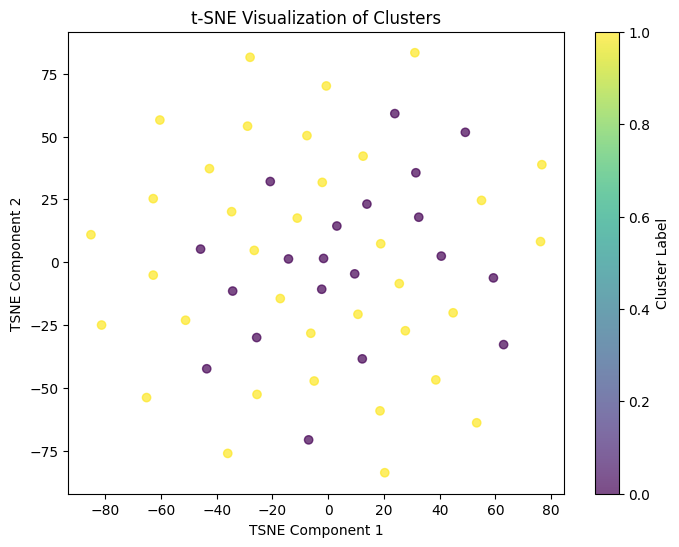

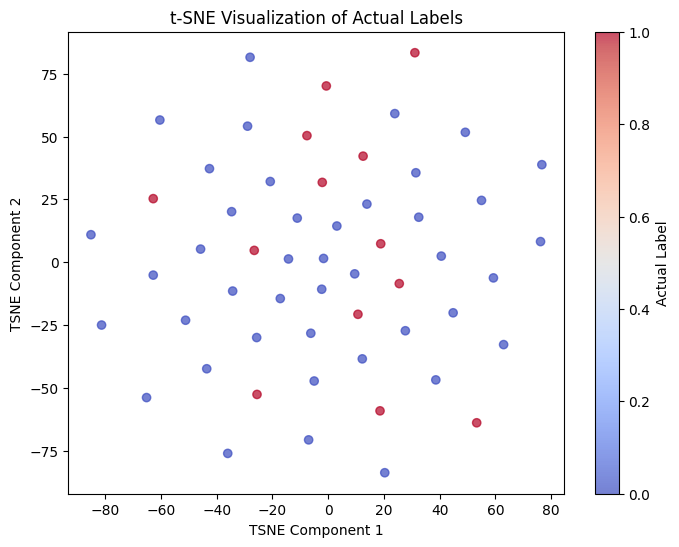

In [33]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load your data
# Assuming 'features.npy' is of shape (n_samples, 8, 24, 24, 24)
# and 'labels.npy' contains the labels (0 for healthy, 1 for unhealthy)

# Flatten the features
n_samples = features.shape[0]
flattened_features = features.reshape(n_samples, -1)
print('Shape of flattened features:', flattened_features.shape)
# Output: (n_samples, 110592)

# Standardize the features
scaler = StandardScaler()
flattened_features_std = scaler.fit_transform(flattened_features)

# Dimensionality reduction using PCA
# Adjust n_components based on the explained variance ratio
pca = PCA(n_components=50, random_state=42)
features_pca = pca.fit_transform(flattened_features_std)
print('Shape after PCA:', features_pca.shape)

# Clustering using KMeans
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(features_pca)

# Evaluate clustering
ari = adjusted_rand_score(labels, clusters)
sil_score = silhouette_score(features_pca, clusters)
print('Adjusted Rand Index:', ari)
print('Silhouette Score:', sil_score)

# Visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_pca)

plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Optional: Visualize actual labels
plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.title('t-SNE Visualization of Actual Labels')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.colorbar(label='Actual Label')
plt.show()

# Suggestions:
# - Experiment with different numbers of PCA components.
# - Try other clustering algorithms like DBSCAN or Agglomerative Clustering.
# - Consider using UMAP for dimensionality reduction.
# - Since you have labels, you might also train a classifier to evaluate feature separability.